In [1]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 4

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data_tomato",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8602 files belonging to 4 classes.


In [8]:
len(dataset) * 16

8608

In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

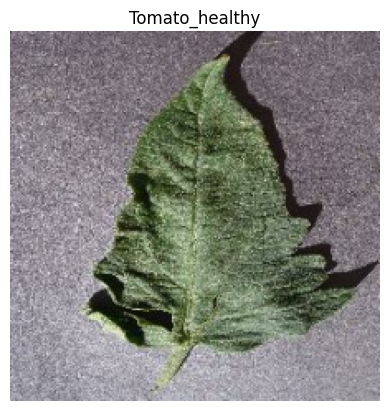

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

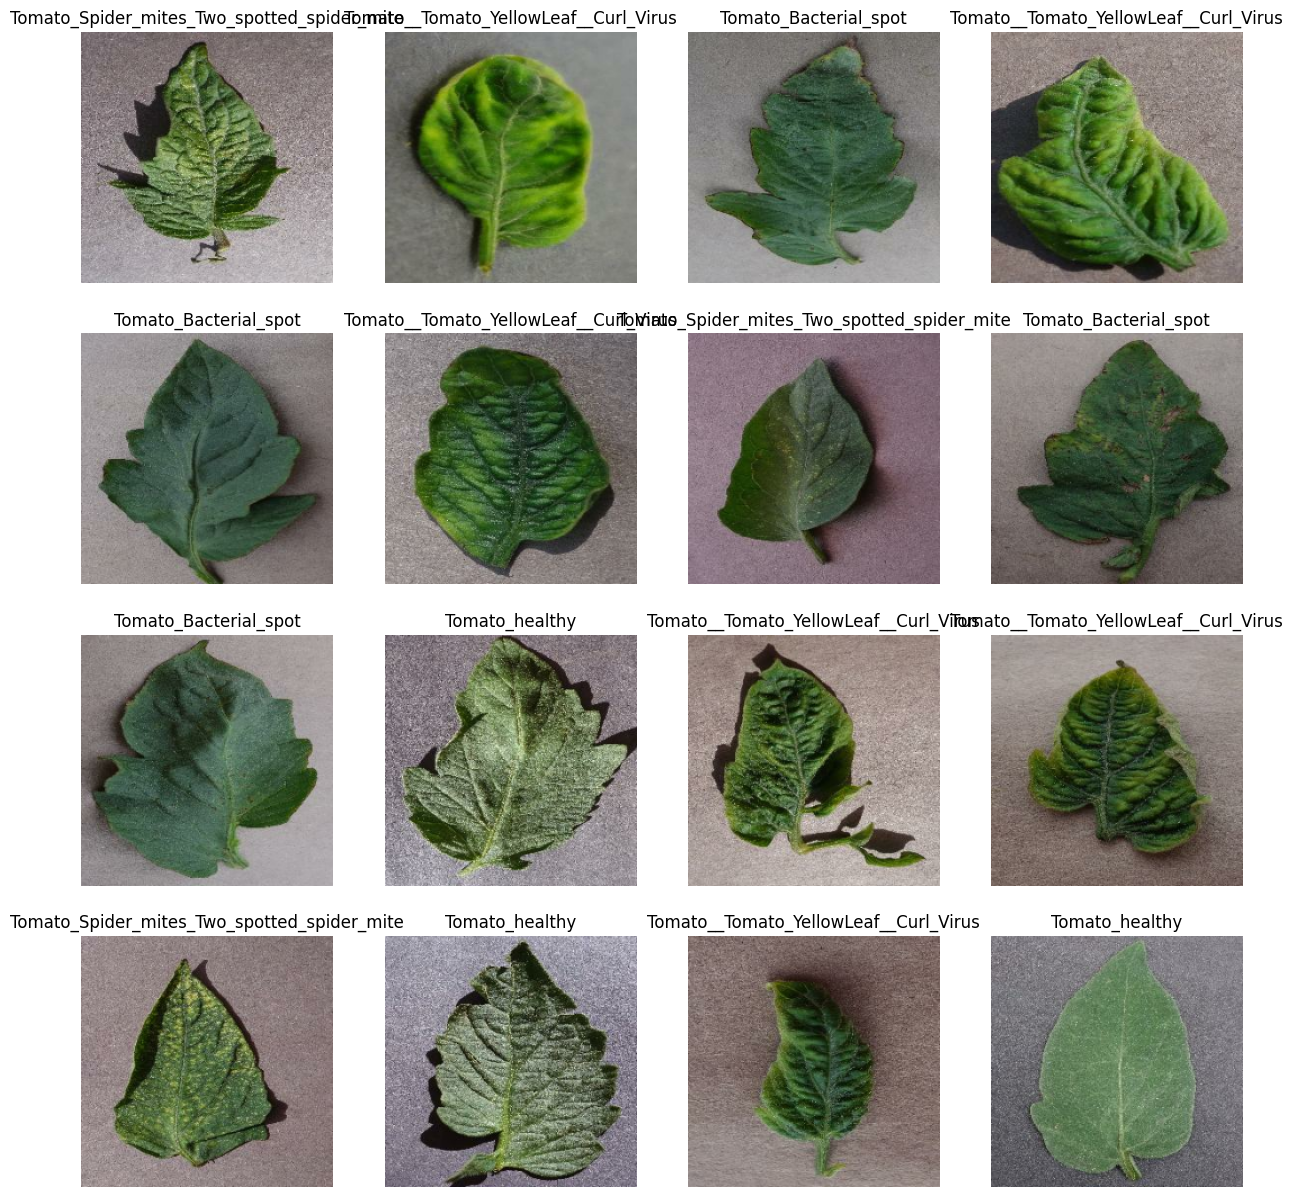

In [12]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [17]:
train_size = 0.85
len(dataset)*train_size

457.3

In [18]:
train_df = dataset.take(457)    ## it's similar to arr[:450]
len(train_df)

457

In [20]:
test_df = dataset.skip(457)   # similar to arr[450:]
len(test_df)

81

In [21]:
val_size = 0.1
len(dataset)*val_size

53.800000000000004

In [22]:
val_df = test_df.take(53)
len(val_df)

53

In [23]:
def get_dataset_partitions_tf(df, train_split=0.85, val_split=0.1, test_split=0.05, shuffle=True, shuffle_size = 10000):
    df_size = len(df)
    if shuffle:
        df = df.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_df = df.take(train_size)

    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)

    return train_df, val_df, test_df

In [24]:
train_df, val_df, test_df = get_dataset_partitions_tf(dataset)

In [25]:
print(f"The Training dataset size is {len(train_df)}")
print(f"The validation dataset size is {len(val_df)}")
print(f"The testing dataset size is {len(test_df)}")

The Training dataset size is 457
The validation dataset size is 53
The testing dataset size is 28


In [26]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [28]:
## Data Augmentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
    
])
model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 54, 54, 64)          0         
 g2D)                                                 

In [31]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_df,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_df
)

Epoch 1/4
457/457 [==============================] - 128s 270ms/step - loss: 0.7050 - accuracy: 0.7115 - val_loss: 0.5309 - val_accuracy: 0.7838
Epoch 2/4
457/457 [==============================] - 130s 285ms/step - loss: 0.4125 - accuracy: 0.8429 - val_loss: 0.2751 - val_accuracy: 0.8955
Epoch 3/4
457/457 [==============================] - 131s 286ms/step - loss: 0.3410 - accuracy: 0.8738 - val_loss: 0.4393 - val_accuracy: 0.8207
Epoch 4/4
457/457 [==============================] - 125s 274ms/step - loss: 0.2580 - accuracy: 0.9041 - val_loss: 0.2200 - val_accuracy: 0.9192
